In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from io import BytesIO
from azure.storage.blob import BlobServiceClient
from sklearn.metrics import silhouette_score
import pickle

In [2]:
connection_string = 'DefaultEndpointsProtocol=https;AccountName=stockanomaly1;AccountKey=O/zmEH0urLFXzD/RWyf0kXKTWwjIZbJ64zU+MfRepFFTj27oHR39A48elx9IdeOcYvWgWAtIa4k9+AStTgp5jQ==;EndpointSuffix=core.windows.net'
container_name = "containerstock"
blob_name = "MSFT.csv"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)
blob_client = container_client.get_blob_client(blob_name)
blob_stream = blob_client.download_blob().readall()
df = pd.read_csv(BytesIO(blob_stream), parse_dates=["Date"])

In [3]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [4]:
df["Date"]=pd.to_datetime(df["Date"],errors='coerce')

In [5]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
duplicate = df[df.duplicated()]
duplicate

,Date,Open,High,Low,Close,Volume


Text(0.5, 1.0, 'Change in the stock price of Google over the years')

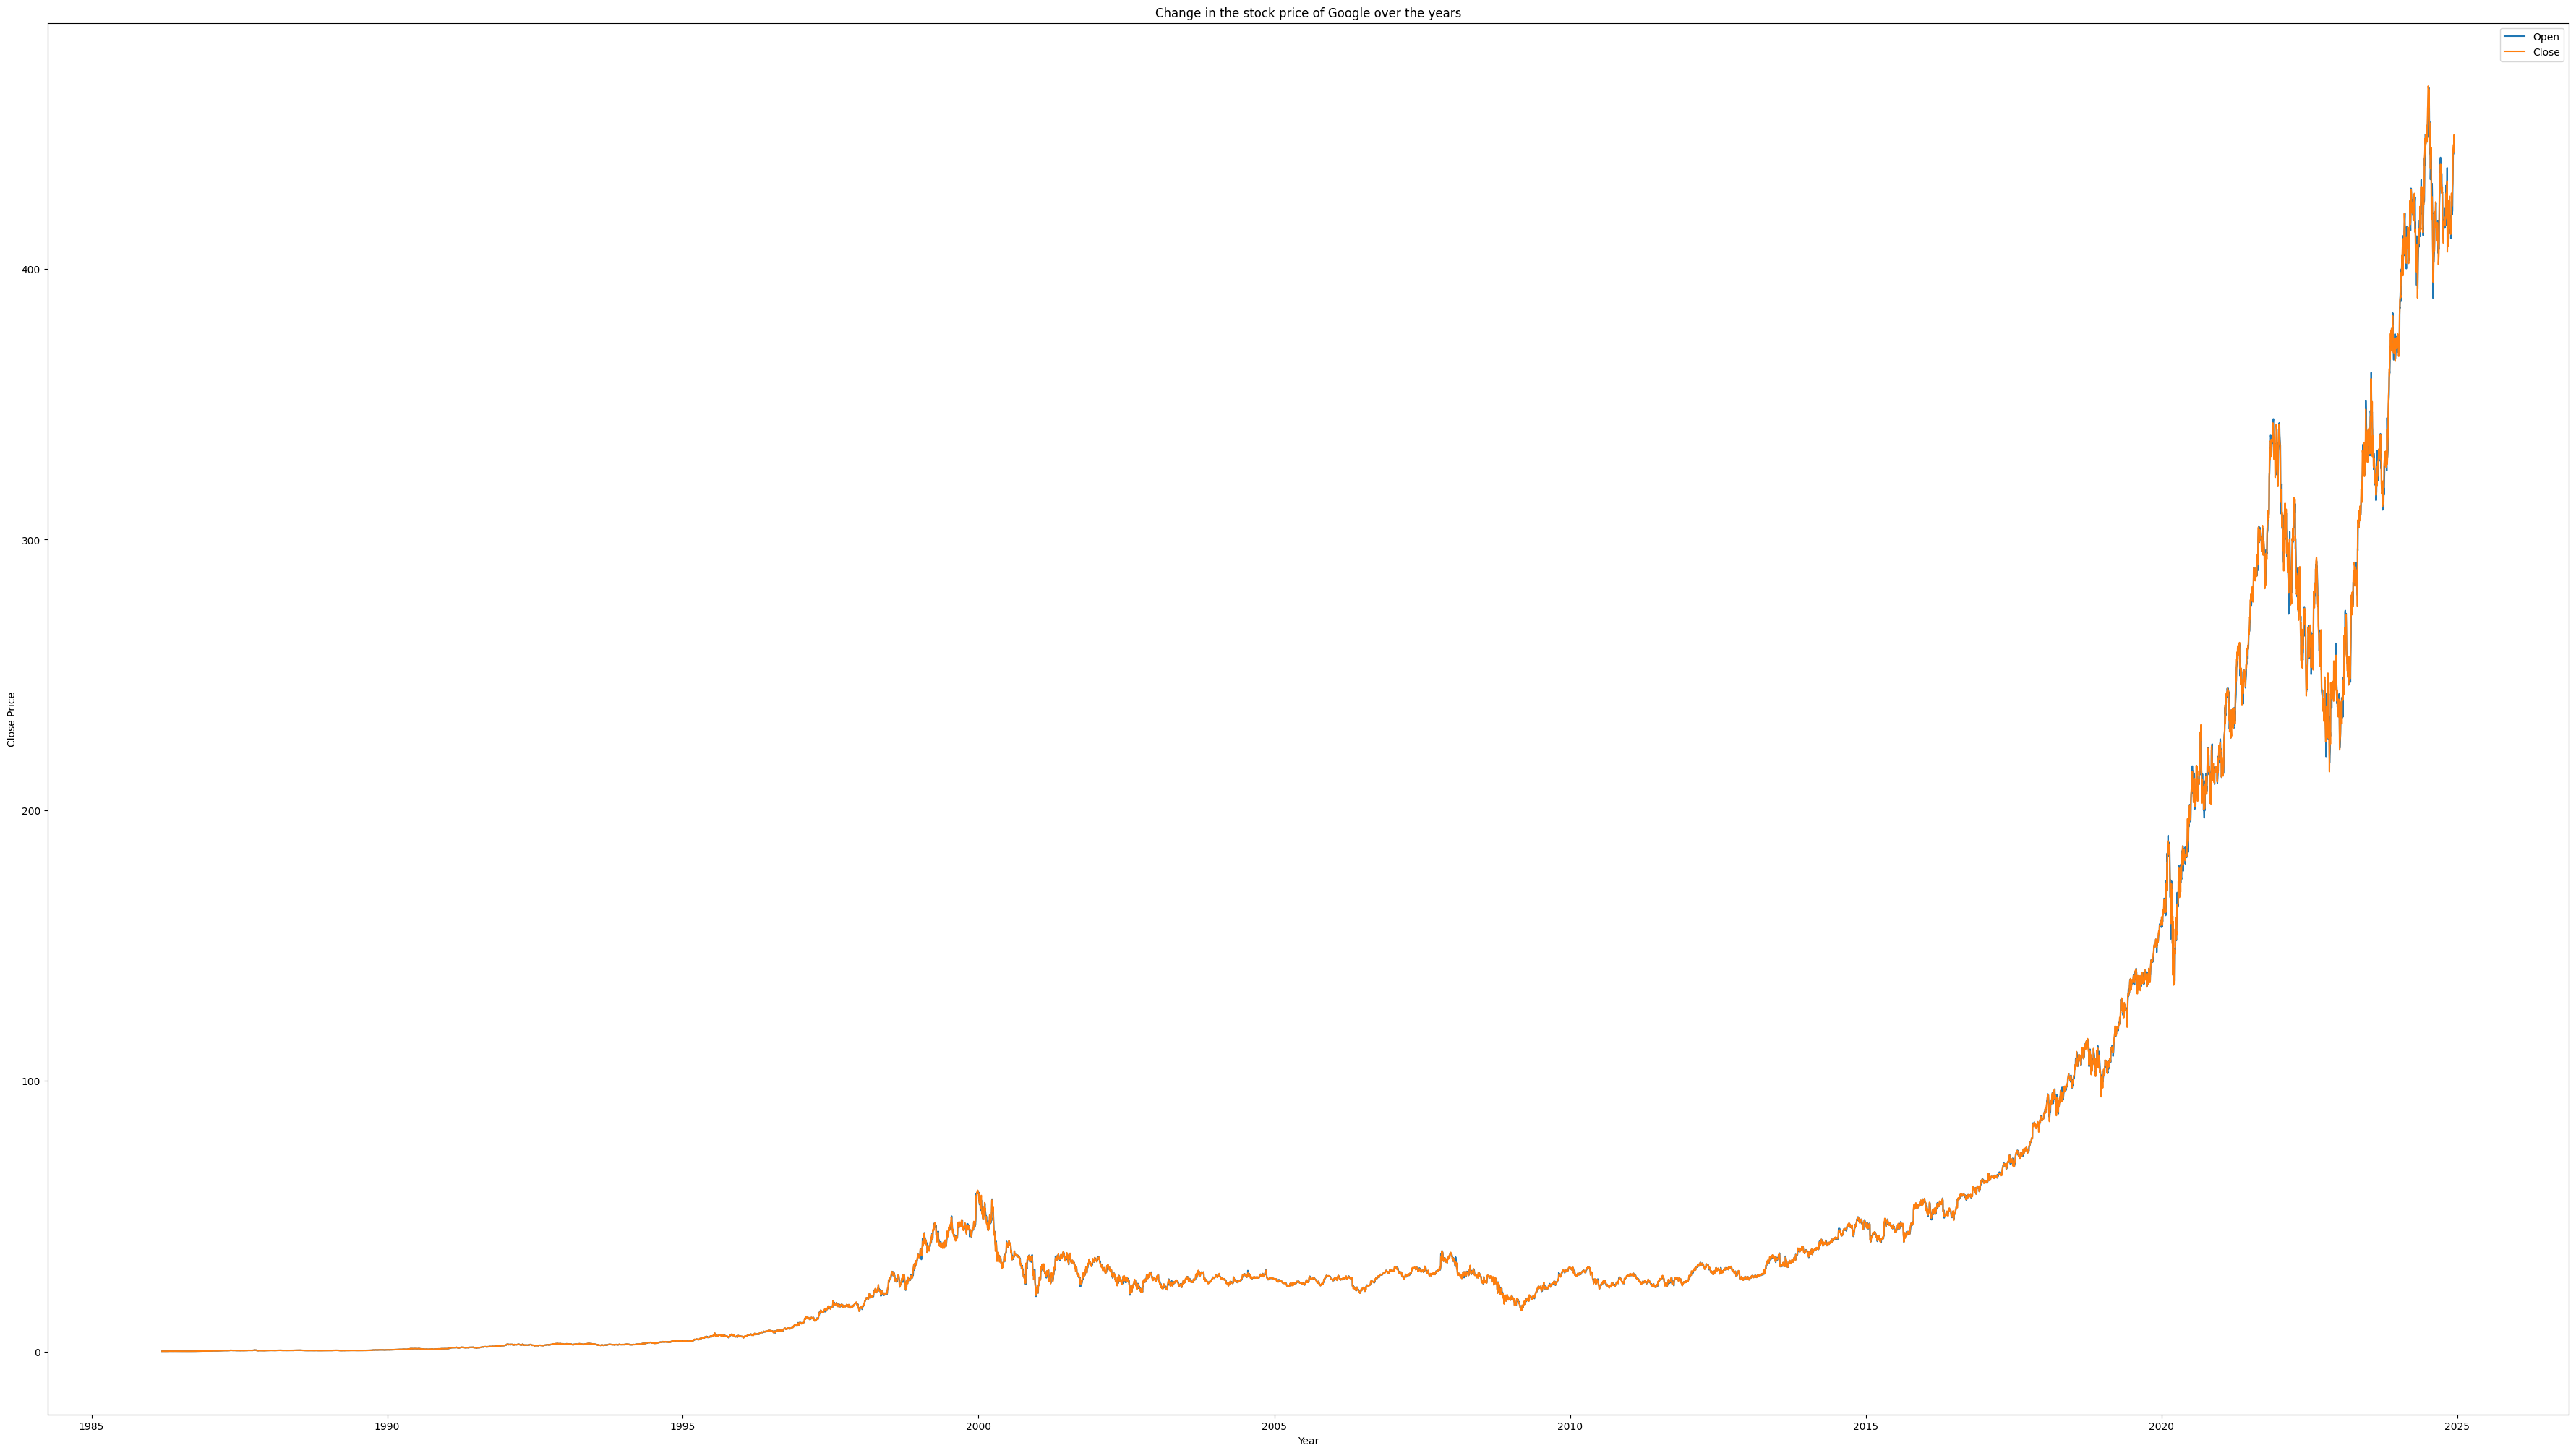

In [7]:
plt.figure(figsize=(45,25))
plt.plot(df['Date'],df['Open'], label='Open')
plt.plot(df['Date'],df['Close'], label='Close')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.title('Change in the stock price of Google over the years')

<Axes: xlabel='Date', ylabel='Rolling Average'>

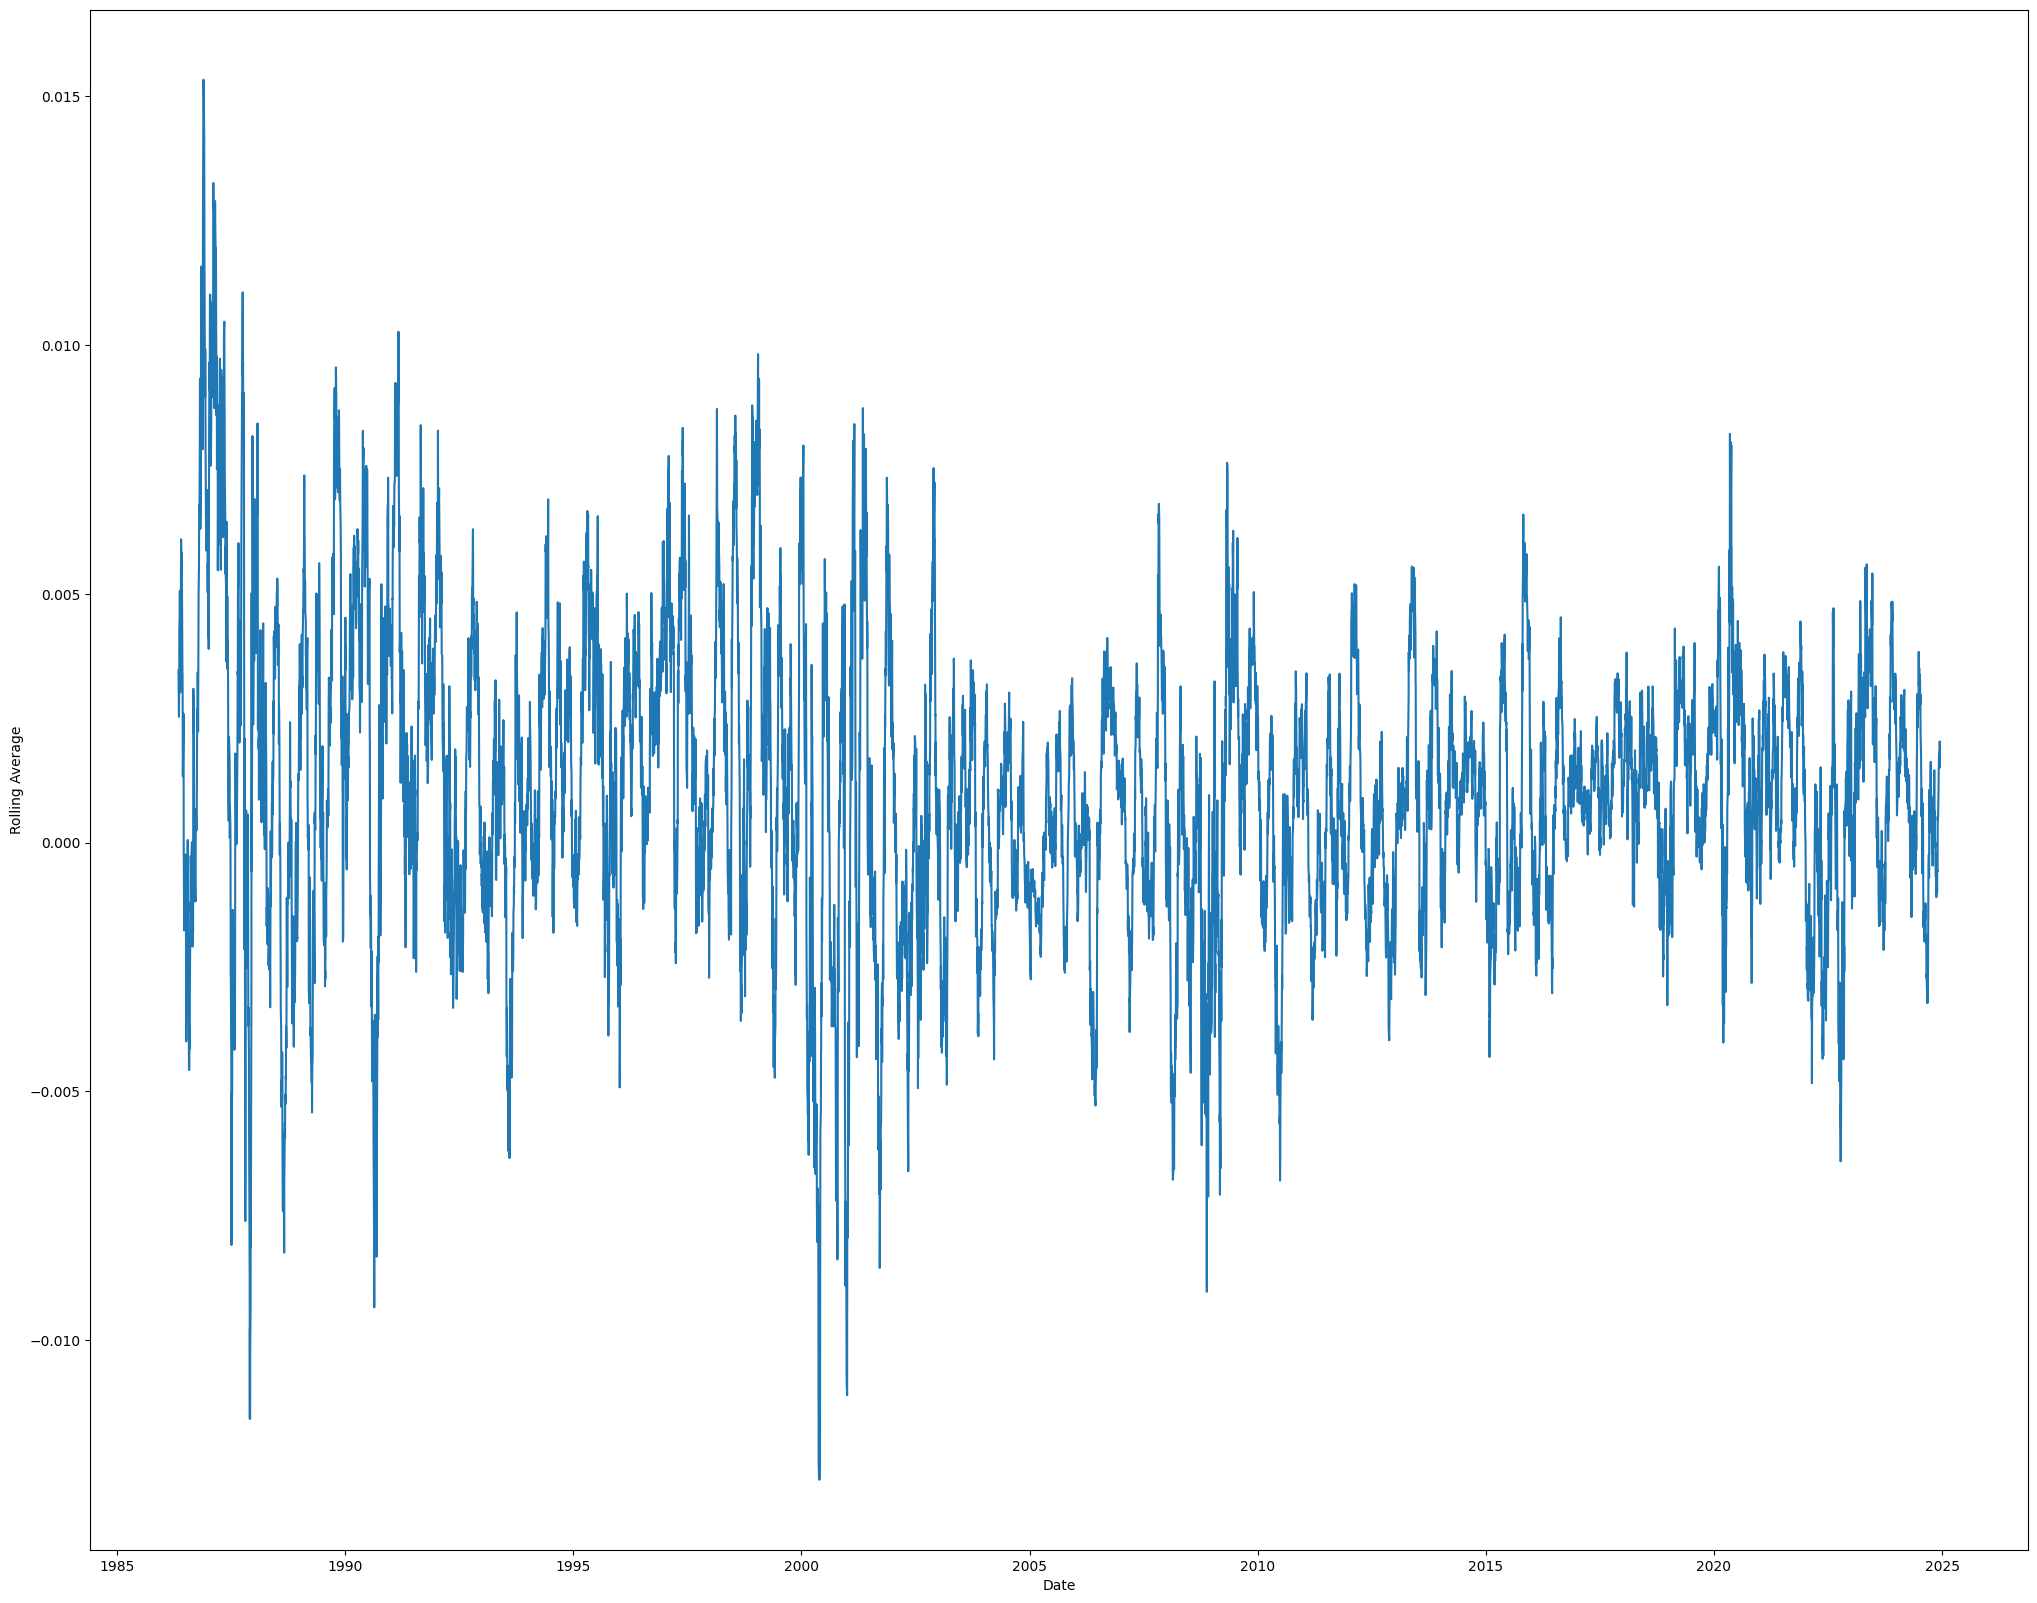

In [8]:
df['Returns'] = df['Close'].pct_change()
df['Rolling Average'] = df['Returns'].rolling(window=40).mean()
plt.figure(figsize=(25,20))
sns.lineplot(x='Date', y='Rolling Average',data=df)

<Axes: >

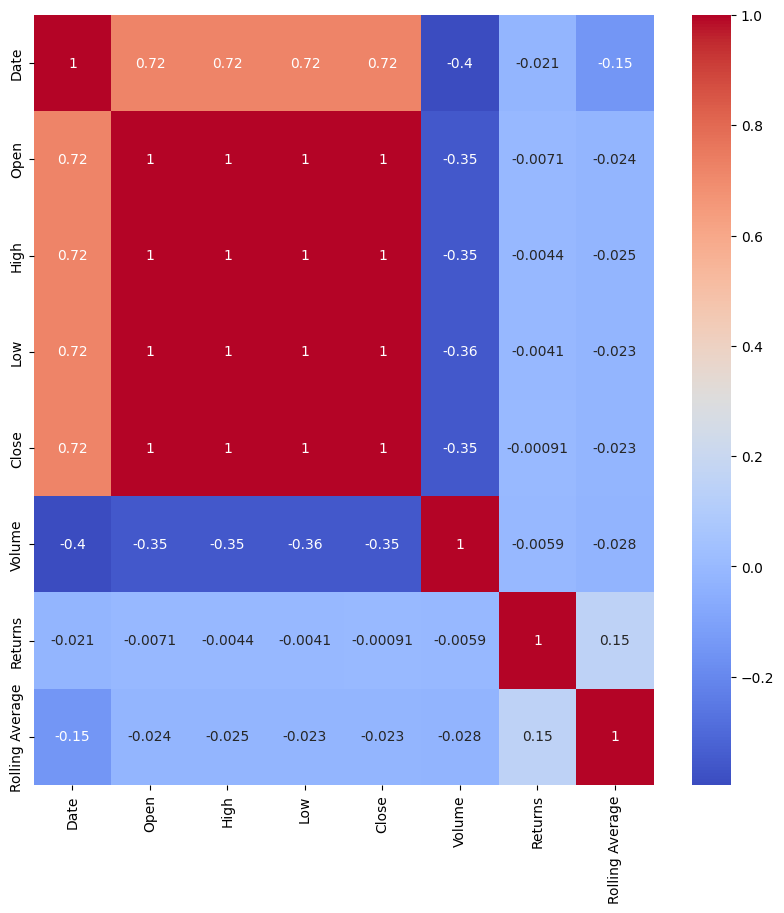

In [9]:
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,cmap='coolwarm')

In [10]:
scaler= StandardScaler()
df['Returns'] = scaler.fit_transform(df['Returns'].values.reshape(-1,1))
df.head()

,Date,Open,High,Low,Close,Volume,Returns,Rolling Average
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,1.031789e+09,NaN,NaN
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,3.081600e+08,1.644341,NaN
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,1.331712e+08,0.767607,NaN
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,6.776640e+07,-1.259323,NaN
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,4.789440e+07,-0.877440,NaN


In [11]:
df['Returns'] = df['Returns'].fillna(df['Returns'].mean())
df['Rolling Average'] = df['Rolling Average'].fillna(df['Rolling Average'].mean())

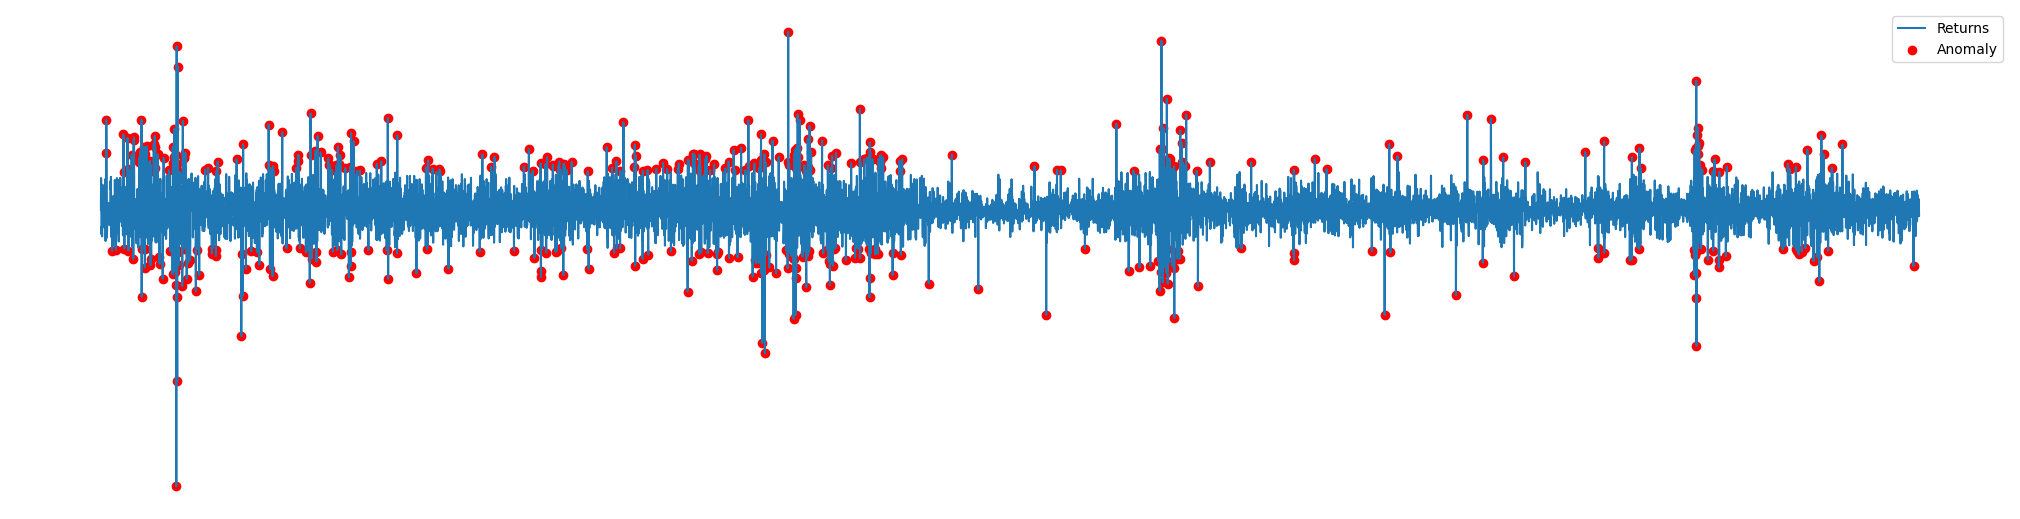

In [12]:
model=IsolationForest(contamination=0.05)
model.fit(df[['Returns']])

df['Anomaly'] = model.predict(df[['Returns']])
df['Anomaly'] = df['Anomaly'].map({1:0,-1:1})

plt.figure(figsize=(20,5))
plt.plot(df.index,df['Returns'],label='Returns')
plt.scatter(df[df['Anomaly']==1].index,df[df['Anomaly']==1]['Returns'],color='red')
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.legend(['Returns','Anomaly'])
plt.savefig("anomaly.png", dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [14]:
blob_name2 = "New_MSFT.csv"
blob_client2 = container_client.get_blob_client(blob_name2)
blob_stream = blob_client2.download_blob().readall()
data_blob2 = pd.read_csv(BytesIO(blob_stream), parse_dates=["Date"])
blob_client2.upload_blob(df.to_csv(index=False), overwrite=True)


{'etag': '"0x8DD1CB6DACB7479"',
 'last_modified': datetime.datetime(2024, 12, 15, 3, 16, 23, tzinfo=datetime.timezone.utc),
 'content_md5': bytearray(b'\xb0v\xb6\xff\x9b5\xd2"Z<e+\x9a\x9d\xd8\x8b'),
 'client_request_id': 'e5aff92b-ba92-11ef-b06e-f8633f343f5e',
 'request_id': 'e70139c7-a01e-00e0-2d9f-4eb41f000000',
 'version': '2025-01-05',
 'version_id': '2024-12-15T03:16:23.6880777Z',
 'date': datetime.datetime(2024, 12, 15, 3, 16, 23, tzinfo=datetime.timezone.utc),
 'request_server_encrypted': True,
 'encryption_key_sha256': None,
 'encryption_scope': None,
 'structured_body': None}

# Evaluation

In [15]:
X=df[["Returns"]]
dbscan=DBSCAN(eps=0.1,min_samples=5)
lbls=dbscan.fit_predict(X)
df['Cluster Labels']=lbls
slh_avg=silhouette_score(X,lbls)
print(f"The silhouette Score is : {slh_avg:.2f}")

The silhouette Score is : 0.68


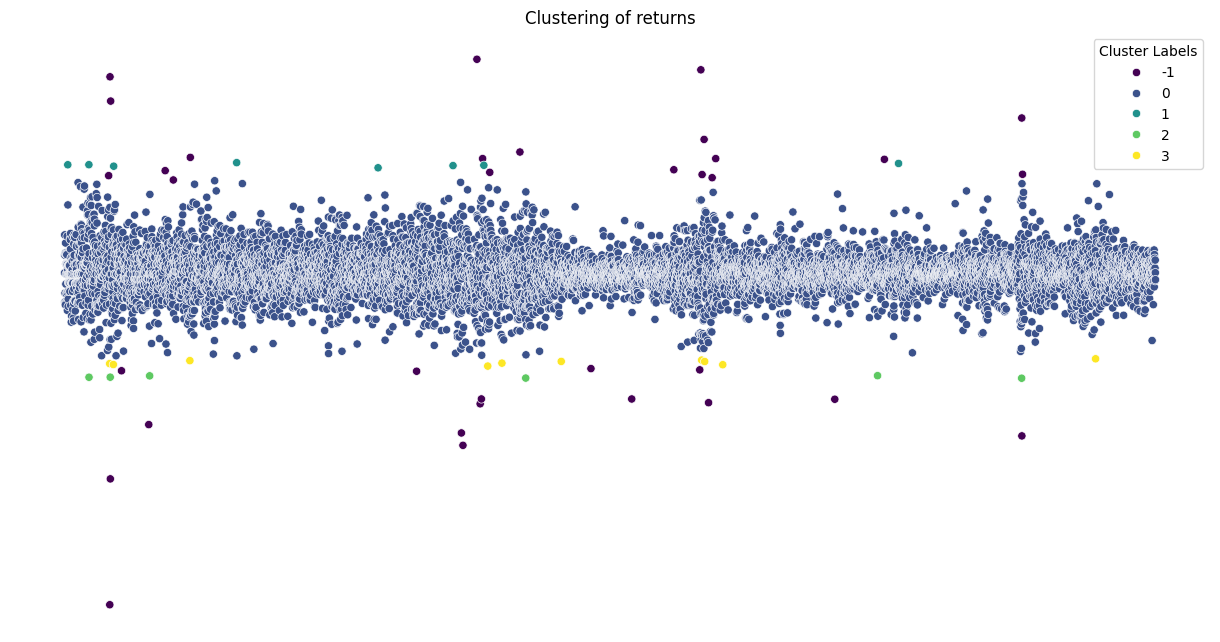

In [16]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=df.index, y=df['Returns'], hue=df['Cluster Labels'], palette='viridis', legend='full')
plt.title("Clustering of returns")
plt.xlabel('Index')
plt.ylabel('Returns')
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig("evaluate.png", dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [17]:
df_sub=df.tail(30)

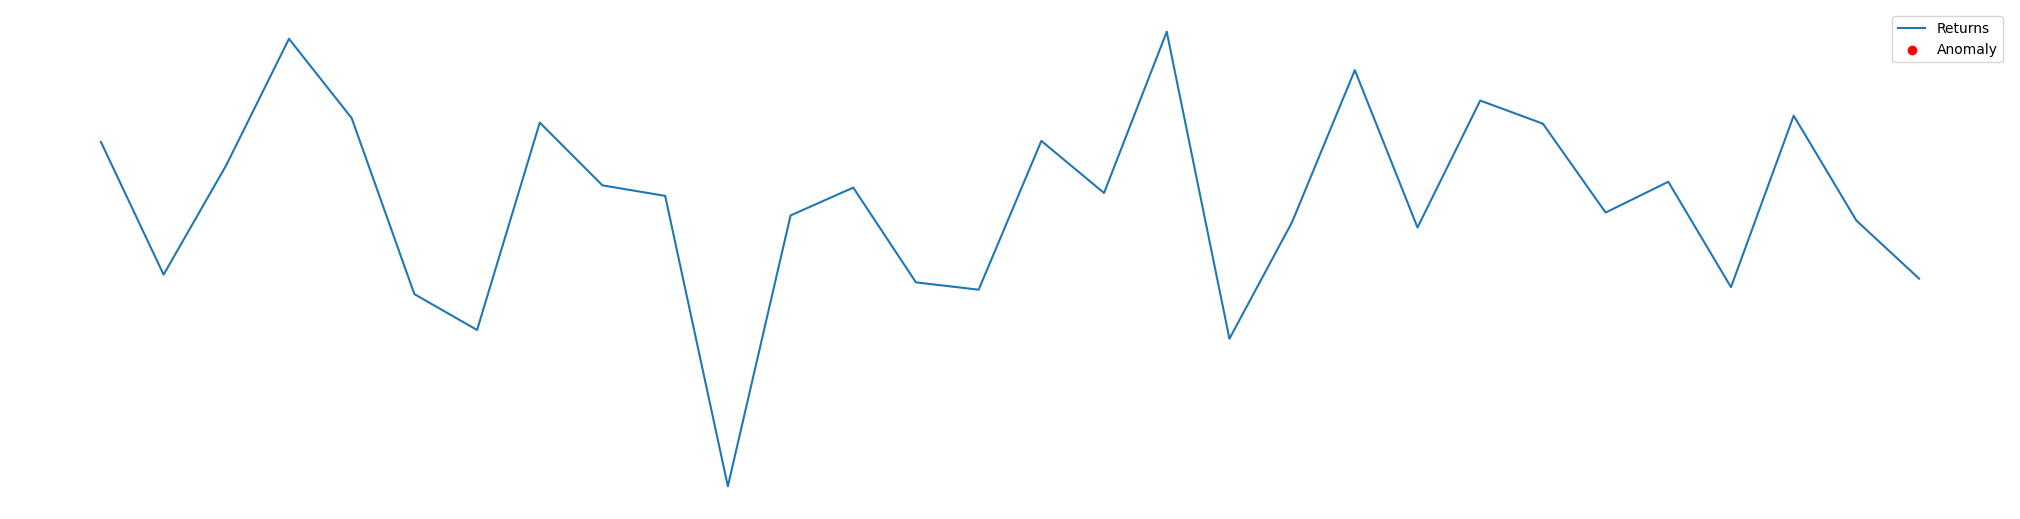

In [18]:
plt.figure(figsize=(20,5))
plt.plot(df_sub.index,df_sub['Returns'],label='Returns')
plt.scatter(df_sub[df_sub['Anomaly']==1].index,df_sub[df_sub['Anomaly']==1]['Returns'],color='red')
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.legend(['Returns','Anomaly'])
plt.savefig("anomaly_month.png", dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

# Making a predictive system

In [19]:
def anomaly_prediction(open_price, high_price, low_price, close_price, previous_close,scaler,model):

    returns = (close_price - previous_close) / previous_close
    scaled_returns = scaler.transform(np.array([[returns]]))  
    
    scaled_returns_df = pd.DataFrame(scaled_returns, columns=['Returns'])

    model_prediction = model.predict(scaled_returns_df)
    is_anomaly = 1 if model_prediction == -1 else 0 

    result = {
        'original_price': {
            'open': open_price,
            'high': high_price,
            'low': low_price,
            'close': close_price,
            'previous_close': previous_close
        },
        'returns': returns,
        'scaled_returns': scaled_returns[0][0],
        'model_prediction': model_prediction[0],
        'is_anomaly': is_anomaly
    }
    
    return result